In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.array as da
import dask.bag as db

In [2]:
product_info = pd.read_csv("./data/Iowa_Liquor_Products.csv")

In [3]:
product_info.columns = [x.replace(" ", "") if x != "Bottle Volume (ml)" else "BottleVolumeML" for x in product_info.columns]

In [129]:
# We understand that this report is generated on the first of April. All values in the last column are redundant.
product_info.ReportDate.unique()

array(['04/01/2022'], dtype=object)

In [131]:
# So we just drop it immediately, no need to play around with it.
product_info.drop('ReportDate', inplace = True, axis=1)

In [4]:
len(product_info.ItemNumber.unique())

10568

In [132]:
product_info[product_info.ItemNumber == "x904631"]

,ItemNumber,CategoryName,ItemDescription,Vendor,VendorName,BottleVolumeML,Pack,InnerPack,Age,Proof,ListDate,UPC,SCC,StateBottleCost,StateCaseCost,StateBottleRetail


In [5]:
product_info.loc[1863, 'ItemNumber'] = '9904631'

In [6]:
# product_info.ItemNumber = product_info.ItemNumber.astype(int)
# we'll do this at the end, it causes problems for us throughout the analysis

In [7]:
invoice_ddf = dd.read_parquet("./data/invoice/part.*.parquet")

In [86]:
invoice_ddf.columns = invoice_ddf.columns.str.replace(" ", "")
invoice_ddf.columns = invoice_ddf.columns.str.replace("Invoice/ItemNumber", 'InvoiceNumber')

In [87]:
invoice_ddf.columns[0]

'InvoiceNumber'

In [15]:
invoice_ddf = invoice_ddf.replace({'ItemNumber': {"x904631": "9904631"}})

In [16]:
invoice_ddf[invoice_ddf.ItemNumber == 'x904631']

,Invoice/ItemNumber,Date,StoreNumber,CountyNumber,VendorNumber,ItemNumber,BottlesSold


In [17]:
invoice_ddf.loc[invoice_ddf['VendorNumber'].isna()]

,Invoice/ItemNumber,Date,StoreNumber,CountyNumber,VendorNumber,ItemNumber,BottlesSold
6001,INV-23231800001,11/14/2019,3869,52.0,NaN,984151,12
39060,INV-33728600005,01/25/2021,2633,77.0,NaN,988100,12
4892,INV-33740700003,01/25/2021,3773,57.0,NaN,915574,6
18452,INV-35139200005,03/18/2021,5251,17.0,NaN,965108,18
3161,INV-35973800003,04/20/2021,6035,52.0,NaN,915574,6
17830,INV-13688900001,08/07/2018,4167,31.0,NaN,973449,36
10224,INV-00993400006,10/17/2016,2190,77.0,NaN,916456,30
21999,INV-00993400007,10/17/2016,2190,77.0,NaN,927565,18
13195,INV-12438800004,06/04/2018,3773,57.0,NaN,910621,12


In [85]:
product_info[product_info.ItemNumber == '1618']

,ItemNumber,CategoryName,ItemDescription,Vendor,VendorName,BottleVolumeML,Pack,InnerPack,Age,Proof,ListDate,UPC,SCC,StateBottleCost,StateCaseCost,StateBottleRetail,ReportDate


In [54]:
item_to_vendor = dict(zip(product_info.ItemNumber.astype(str), product_info.Vendor))

In [87]:
# some of these items are not showing up because they are discontinued. Would have to dig futher back to get this info
item_to_vendor['40946'] = 260
item_to_vendor['57090'] = 35
item_to_vendor['1618'] = 55

In [33]:
# type fixing so we don't get owned later w/ the comparison
continuing_product = product_info.ItemNumber.unique().astype(str)
unique_ids = invoice_ddf.ItemNumber.unique().astype(str)

In [34]:
discontinued = list(set(unique_ids) - set(continuing_product))

In [37]:
print(f"Products still in circulation: {len(continuing_product)}")
print(f"Products discontinued: {len(discontinued)}")
print(f"Total Products: {len(unique_ids)}")

Products still in circulation: 10568
Products discontinued: 1524
Total Products: 11013


In [28]:
len(unique_ids)

11013

In [35]:
len(discontinued)

1524

In [38]:
disc_mask = invoice_ddf.ItemNumber.isin(discontinued)

In [39]:
# should be ~150k
sum(disc_mask)

151562

In [41]:
discontinued_df = invoice_ddf[invoice_ddf.ItemNumber.isin(discontinued)]

In [42]:
# safely save our data elsewhere, and then remove this from our actual df
discontinued_df.to_csv("./data/discontinued/old_invoices.csv")

In [43]:
# trim the df and check shape
invoice_ddf = invoice_ddf[~invoice_ddf.ItemNumber.isin(discontinued)]
invoice_ddf.shape[0]

23194526

In [ ]:
invoice_ddf['ItemNumber'].map(lambda x: item_to_vendor[x])

In [56]:
invoice_ddf['VendorNumber'] = invoice_ddf['ItemNumber'].map(lambda x: item_to_vendor[x])

In [57]:
invoice_ddf.loc[invoice_ddf['VendorNumber'].isna()]

,Invoice/ItemNumber,Date,StoreNumber,CountyNumber,VendorNumber,ItemNumber,BottlesSold


In [82]:
invoice_ddf['Year'] = invoice_ddf.Date.map(lambda x: x[-4:])

In [88]:
invoice_ddf.head()

,InvoiceNumber,Date,StoreNumber,CountyNumber,VendorNumber,ItemNumber,BottlesSold,Year
0,S12495000021,05/30/2013,3525,92.0,297,35926,12,2013
1,S18125600027,03/27/2014,3909,63.0,297,23824,8,2014
2,S21049000029,09/04/2014,2152,17.0,421,12888,2,2014
3,S25095700018,04/15/2015,3715,82.0,420,48106,4,2015
4,S13846100032,08/15/2013,4288,57.0,421,53216,4,2013


In [91]:
invoice_ddf['Year'].unique()

array(['2013', '2014', '2015', '2012', '2022', '2018', '2019', '2016',
       '2017', '2020', '2021'], dtype=object)

In [60]:
invoice_ddf[invoice_ddf.BottlesSold.isna()]

,Invoice/ItemNumber,Date,StoreNumber,CountyNumber,VendorNumber,ItemNumber,BottlesSold


In [73]:
total_sold_alltime = invoice_ddf.groupby('ItemNumber').agg({'BottlesSold' : sum, 'VendorNumber' : 'count'}).rename(columns = {'VendorNumber' : 'UniqueTransactions'})

In [77]:
total_sold_alltime = total_sold_alltime.reset_index()

In [79]:
total_sold_alltime = total_sold_alltime.astype({"ItemNumber": int, "BottlesSold": int, "count": int})

In [93]:
total_sold_per_year = invoice_ddf.groupby(['ItemNumber', 'Year']).agg({'BottlesSold' : sum, 'VendorNumber' : 'count'}).rename(columns = {'VendorNumber' : 'UniqueTransactions'})

In [95]:
total_sold_per_year = total_sold_per_year.reset_index()

In [99]:
total_sold_alltime.to_csv("./data/alltime_sales.csv")
total_sold_per_year.to_csv("./data/yearly_summed_sales.csv")

In [100]:
# will be useful for visualizations later but not really right now
total_sold_per_year.pivot(index='ItemNumber', columns = 'Year', values = ['BottlesSold', 'UniqueTransactions']).fillna(0)

BottlesSold                                                     \
Year              2012 2013 2014 2015   2016    2017   2018   2019   2020   
ItemNumber                                                                  
100001             0.0  0.0  0.0  0.0  120.0   384.0    0.0    0.0    0.0   
100005             0.0  0.0  0.0  0.0  615.0     0.0    0.0    0.0    0.0   
100006             0.0  0.0  0.0  0.0  418.0     0.0    0.0    0.0    0.0   
100015             0.0  0.0  0.0  0.0  874.0   917.0  915.0  849.0  729.0   
100017             0.0  0.0  0.0  0.0  517.0  1370.0  549.0    0.0    0.0   
...                ...  ...  ...  ...    ...     ...    ...    ...    ...   
999991             0.0  0.0  0.0  0.0    0.0     0.0    0.0    0.0    0.0   
999992             0.0  0.0  0.0  0.0    0.0     0.0    0.0    0.0    0.0   
999993             0.0  0.0  0.0  0.0    0.0     0.0    0.0    0.0    0.0   
999994             0.0  0.0  0.0  0.0    0.0     0.0    0.0    0.0    0.0   
999995             0.0  0.0  0.0  0.0    0.0     0.0    0.0    0.0    0.0   

                    ... UniqueTransactions                                 \
Year          2021  ...               2013 2014 2015   2016   2017   2018   
ItemNumber          ...                                                     
100001         0.0  ...                0.0  0.0  0.0   24.0   50.0    0.0   
100005         0.0  ...                0.0  0.0  0.0  128.0    0.0    0.0   
100006         0.0  ...                0.0  0.0  0.0  151.0    0.0    0.0   
100015      1123.0  ...                0.0  0.0  0.0  156.0  231.0  196.0   
100017         0.0  ...                0.0  0.0  0.0   22.0   51.0   26.0   
...            ...  ...                ...  ...  ...    ...    ...    ...   
999991         6.0  ...                0.0  0.0  0.0    0.0    0.0    0.0   
999992         6.0  ...                0.0  0.0  0.0    0.0    0.0    0.0   
999993        48.0  ...                0.0  0.0  0.0    0.0    0.0    0.0   
999994         0.0  ...                0.0  0.0  0.0    0.0    0.0    0.0   
999995         0.0  ...                0.0  0.0  0.0    0.0    0.0    0.0   

                                       
Year         2019   2020   2021  2022  
ItemNumber                             
100001        0.0    0.0    0.0   0.0  
100005        0.0    0.0    0.0   0.0  
100006        0.0    0.0    0.0   0.0  
100015      170.0  149.0  230.0  42.0  
100017        0.0    0.0    0.0   0.0  
...           ...    ...    ...   ...  
999991        0.0    0.0    1.0   0.0  
999992        0.0    0.0    1.0   0.0  
999993        0.0    0.0    3.0   0.0  
999994        0.0    0.0    0.0   1.0  
999995        0.0    0.0    0.0   1.0  

[9489 rows x 22 columns]

In [103]:
total_sold_alltime.sort_values("BottlesSold", ascending = False)

,ItemNumber,BottlesSold,count
3749,64870,8784168,73708
477,11788,5687681,233845
2054,36904,3561889,123387
2773,43337,3159864,100278
1946,36308,3109285,220541
...,...,...,...
7942,946127,1,1
8156,964139,1,1
6479,906532,1,1
9256,994615,1,1


<AxesSubplot:xlabel='count', ylabel='BottlesSold'>

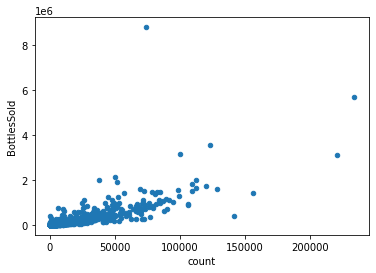

In [109]:
total_sold_alltime[['BottlesSold', 'count']].plot(x = 'count', y = 'BottlesSold', kind='scatter')

In [ ]:
# Looks like there are only a couple of outliers in the data set. One is for a huge # of sold, one is both large raw # sold as well as uniqueTransactions.

In [113]:
noteworthy_ids = total_sold_alltime.sort_values("BottlesSold", ascending = False).head(5).ItemNumber.values

In [122]:
def product_lookup(itemNumbers):
    
    if isinstance(itemNumbers, int):
        item_number = list(itemNumbers)
        
    db = product_info[product_info.ItemNumber.isin(itemNumbers)]
        
    
    if db.shape[0] == 0:
        return "No item found"
    
    return db

def revenue_stitcher(invoices, itemNumbers, all_time = False):
    pass

    if all_time:
        items = product_lookup(itemNumbers)
        

In [128]:
items = product_lookup(noteworthy_ids)

sales = total_sold_alltime[total_sold_alltime.ItemNumber.isin(noteworthy_ids)]

new_df = pd.merge(items, sales)

del items
del sales

new_df['ProfitPerBottle'] = new_df.StateBottleRetail - new_df.StateBottleCost
new_df['ProfitPerCase'] = new_df.StateBottleRetail * new_df.Pack - new_df.StateCaseCost

new_df

,ItemNumber,CategoryName,ItemDescription,Vendor,VendorName,BottleVolumeML,Pack,InnerPack,Age,Proof,...,UPC,SCC,StateBottleCost,StateCaseCost,StateBottleRetail,ReportDate,BottlesSold,count,ProfitPerBottle,ProfitPerCase
0,36308,American Vodkas,Hawkeye Vodka,434,LUXCO INC,1750,6,1,0,80,...,8.835211e+10,10794504446125,7.17,43.02,10.76,04/01/2022,3109285,220541,3.59,21.54
1,36904,American Vodkas,McCormick 80prf Vodka PET,300,McCormick Distilling Co.,375,24,1,0,80,...,8.559210e+10,10811538010266,1.80,43.20,2.70,04/01/2022,3561889,123387,0.90,21.60
2,11788,Canadian Whiskies,Black Velvet,259,Heaven Hill Brands,1750,6,1,0,80,...,9.674900e+10,1108917560019,10.45,62.70,15.68,04/01/2022,5687681,233845,5.23,31.38
3,64870,Whiskey Liqueur,Fireball Cinnamon Whiskey,421,SAZERAC COMPANY INC,100,48,1,0,66,...,8.800401e+10,48415345231,0.90,43.20,1.35,04/01/2022,8784168,73708,0.45,21.60
4,43337,Spiced Rum,Captain Morgan Original Spiced,260,DIAGEO AMERICAS,1000,12,1,0,70,...,8.807617e+10,82000747178,11.75,141.00,17.63,04/01/2022,3159864,100278,5.88,70.56


In [126]:
total_sold_alltime.loc[noteworthy_ids]

KeyError: "None of [Int64Index([64870, 11788, 36904, 43337, 36308], dtype='int64')] are in the [index]"

In [123]:
product_lookup(noteworthy_ids)

,ItemNumber,CategoryName,ItemDescription,Vendor,VendorName,BottleVolumeML,Pack,InnerPack,Age,Proof,ListDate,UPC,SCC,StateBottleCost,StateCaseCost,StateBottleRetail,ReportDate
739,36308,American Vodkas,Hawkeye Vodka,434,LUXCO INC,1750,6,1,0,80,10/01/1989,8.835211e+10,10794504446125,7.17,43.02,10.76,04/01/2022
1144,36904,American Vodkas,McCormick 80prf Vodka PET,300,McCormick Distilling Co.,375,24,1,0,80,11/01/1992,8.559210e+10,10811538010266,1.80,43.20,2.70,04/01/2022
2367,11788,Canadian Whiskies,Black Velvet,259,Heaven Hill Brands,1750,6,1,0,80,02/01/1989,9.674900e+10,1108917560019,10.45,62.70,15.68,04/01/2022
3695,64870,Whiskey Liqueur,Fireball Cinnamon Whiskey,421,SAZERAC COMPANY INC,100,48,1,0,66,06/01/2015,8.800401e+10,48415345231,0.90,43.20,1.35,04/01/2022
3737,43337,Spiced Rum,Captain Morgan Original Spiced,260,DIAGEO AMERICAS,1000,12,1,0,70,10/01/1990,8.807617e+10,82000747178,11.75,141.00,17.63,04/01/2022
